final state of charge 0.9956730769232194
soc [1.         0.99999808 0.99999615 ... 0.99567269 0.99567288 0.99567308]


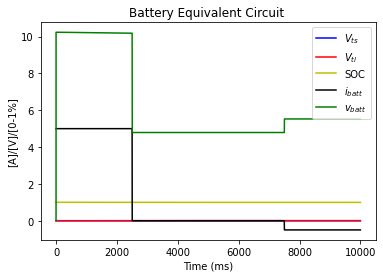

In [31]:
# ONLY DECENT RESULTS SEEM TO COME WHEN PARAMETERS ARE SET FOR DISCHARGE CURRENT OF 0.5A NOT VARIABLE CURRENT
# AUTHORS ALSO DONT SEEM TO HAVE MODELED ZERO CURRENT, IDLE SCENARIOS


import numpy as np
import matplotlib.pyplot as plt
import math

R_ts = 0.78
C_ts = 461
R_tl = 15.5
C_tl = 2141
R_i = 0.00038


x = np.array([0,0,1]) # state vector: current, angular velocity, angular acceleration
duration = 10000 # time steps is 1000
dt = 0.001 # change in time is 1ms
# total time is 1s

C_capacity = 2600
starting_voltage = 4.2

period = int(duration/4)
i_batt = 5*np.ones((period))
i_batt = np.hstack((i_batt, np.zeros((period))))
i_batt = np.hstack((i_batt, np.zeros((period))))
i_batt = np.hstack((i_batt, -0.5*np.ones((period))))

def linear(p0,p1,i):
    return p0 + p1*i

def quadratic(g0,g1,g2, i):
    return g0 + g1*i + g2*i*i

def exponential(b0,b1,b2,i):
    return b0*math.exp(-b1*i) + b2

def VOC(soc, i):
    # default parameters are for discharge current of 0.5A 
    a0 = linear(-.5527, -.205, i) #-.635
    #a0 = -.635
    a1 = 26.8 # constant
    a2 = quadratic(.418, -.023, .109, i) 
    #a2 = .314
    a3 = quadratic(-1.57, -1.23, .36, i) 
    #a3 = -2.02
    a4 = -1.27 # indeterminant
    a5 = 7.2 # indeterminant
    return a0 * math.exp(-a1*soc) + a2*math.pow(soc,3) + a3*math.pow(soc,2) + a4*soc + a5
    
    

def create_A(i):
    # i is applied current
    R_ts = exponential(1.32, 2.06, .14, i)
    C_ts = linear(461.2, -7.03, i)
    R_tl = quadratic(36.4, -29.3, 8.43, i)
    A = np.array([[-1/(R_ts * C_ts) ,       0,              0],
                  [0                ,       -1/(R_tl*C_tl), 0],
                  [0                ,       0,              0]])
    return A

v_batt = np.array([0])
x_hist = x
for i in range(duration):
    A = create_A(i_batt[i])
    C_ts = linear(461.2, -7.03, i)
    dx = A @ x + np.array([1/C_ts, 1/C_tl, -1/C_capacity]) * i_batt[i]
    x = x + dx * dt
    x_hist = np.vstack((x_hist,x))
    v_batt = np.vstack((v_batt, VOC(x[2], i_batt[i]) - R_i*i_batt[i] - x[0] - x[1] ))

print("final state of charge", x[2])
print("soc", x_hist[:,2])
plt.plot(range(len(x_hist[:,0])), x_hist[:,0], 'b')
plt.plot(range(len(x_hist[:,0])), x_hist[:,1], 'r')
plt.plot(range(len(x_hist[:,0])), x_hist[:,2], 'y')
plt.plot(range(len(i_batt)), i_batt, 'k')
plt.plot(range(len(v_batt)), v_batt, 'g')
plt.title("Battery Equivalent Circuit ")
plt.ylabel("[A]/[V]/[0-1%]")
plt.legend([r'$V_{ts}$',r'$V_{tl}$',"SOC",r'$i_{batt}$',r'$v_{batt}$'])
plt.xlabel("Time (ms)")
plt.show()